In [2]:
# Import packages
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [254]:
# Load training data
df_train = pd.read_csv("C:/Users/thanh/Desktop/Deep Learning/nomad2018-predict-transparent-conductors/train.csv")
df_train = df_train.rename(columns = {'spacegroup' : 'sg',
                            'number_of_total_atoms' : 'Natoms',
                            'percent_atom_al' : 'Al_x',
                            'percent_atom_ga' : 'Ga_x',
                            'percent_atom_in' : 'In_x',
                            'lattice_vector_1_ang' : 'a',
                            'lattice_vector_2_ang' : 'b',
                            'lattice_vector_3_ang' : 'c',
                            'lattice_angle_alpha_degree' : 'alpha',
                            'lattice_angle_beta_degree' : 'beta',
                            'lattice_angle_gamma_degree' : 'gamma',
                            'formation_energy_ev_natom' : 'Ef',
                            'bandgap_energy_ev' : 'Eg'})
df_train.head()
df_rf_train = df_train

In [255]:
# Load test data
df_test = pd.read_csv("C:/Users/thanh/Desktop/ML Project/testEgEf.csv")
df_test = df_test.rename(columns = {'spacegroup' : 'sg',
                            'number_of_total_atoms' : 'Natoms',
                            'percent_atom_al' : 'Al_x',
                            'percent_atom_ga' : 'Ga_x',
                            'percent_atom_in' : 'In_x',
                            'lattice_vector_1_ang' : 'a',
                            'lattice_vector_2_ang' : 'b',
                            'lattice_vector_3_ang' : 'c',
                            'lattice_angle_alpha_degree' : 'alpha',
                            'lattice_angle_beta_degree' : 'beta',
                            'lattice_angle_gamma_degree' : 'gamma',
                            'formation_energy_ev_natom' : 'Ef',
                            'bandgap_energy_ev' : 'Eg'})
df_test.head()
df_rf_test = df_test

In [5]:
# Get elemental data list
def get_list(data_path):
    return [f[:-4] for f in os.listdir(data_path)]

# Folder contains elemental data
data_path = 'C:/Users/thanh/Desktop/Deep Learning/nomad2018-predict-transparent-conductors/elemental-files'
# Get list of properties which have data files
properties = get_list(data_path)
print(sorted(properties))

# retrieve elemental properties
def grep_prop(prop, data_path):
    dat = os.path.join(data_path, prop + '.txt')
    with open(dat, 'r') as d:
        all_els = {line.split(',')[0].strip(): float(line.split(',')[1].strip().strip('"').strip()) for line in d}

    my_els = ['Al', 'Ga', 'In']

    return {el : all_els[el] for el in all_els if el in my_els}

# Make nested dictionary which maps {property (str) : {element (str) : property value (float)}}
prop_dict = {prop : grep_prop(prop, data_path) for prop in properties}

# Test
#print('The HOMO of Ga is %.3f eV' % prop_dict['HOMO']['Ga'])

['EA', 'HOMO', 'IP', 'LUMO', 'bulkmodulus', 'electronegativity', 'mass', 'meltingpoint', 'rd_max', 'rp_max', 'rs_max']
The HOMO of Ga is -2.732 eV


In [6]:
# Calculate properties for each compound
def avg_prop(Al_x, Ga_x, In_x, prop):
    els = ['Al', 'Ga', 'In']
    concentration_dict = dict(zip(els, [Al_x, Ga_x, In_x]))
    return sum(prop_dict[prop][el] * concentration_dict[el] for el in els)

# Add averaged properties to DataFrame
for prop in properties:
    df_train['_'.join(['avg', prop])] = avg_prop(df_train['Al_x'], df_train['Ga_x'], df_train['In_x'], prop)
    df_test['_'.join(['avg', prop])] = avg_prop(df_test['Al_x'], df_test['Ga_x'], df_test['In_x'], prop)

df_test.head()

,id,sg,Natoms,Al_x,Ga_x,In_x,a,b,c,alpha,...,avg_EA,avg_electronegativity,avg_HOMO,avg_IP,avg_LUMO,avg_mass,avg_meltingpoint,avg_rd_max,avg_rp_max,avg_rs_max
0,1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,...,-0.206171,1.762367,-2.743588,-5.715080,0.368885,77.219609,2208.9053,2.262705,1.382636,1.050729
1,2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,...,-0.219250,1.660000,-2.705750,-5.789550,0.308500,37.666904,2302.0000,2.872500,1.457500,1.095000
2,3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,...,-0.240989,1.671840,-2.717607,-5.746505,0.382873,48.751576,2289.5567,2.756907,1.453474,1.100107
3,4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,...,-0.191462,1.697500,-2.712313,-5.796712,0.263875,45.680928,2269.7500,2.694375,1.425625,1.068750
4,5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,...,-0.199763,1.763125,-2.741688,-5.723287,0.351187,75.801163,2208.3750,2.269375,1.380625,1.047500


In [7]:
# Convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['alpha', 'beta', 'gamma']
for lang in lattice_angles:
    df_train['_'.join([lang, 'r'])] = np.pi * df_train[lang] / 180
    df_test['_'.join([lang, 'r'])] = np.pi * df_test[lang] / 180

# Calculate the volume of the structure
def get_vol(a, b, c, alpha, beta, gamma):
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma) - np.cos(alpha)**2 - np.cos(beta)**2 - np.cos(gamma)**2)

df_train['vol'] = get_vol(df_train['a'], df_train['b'], df_train['c'], df_train['alpha_r'], df_train['beta_r'], df_train['gamma_r'])
df_test['vol'] = get_vol(df_test['a'], df_test['b'], df_test['c'], df_test['alpha_r'], df_test['beta_r'], df_test['gamma_r'])
#df_train[['a','b','c','alpha_r','beta_r','gamma_r','vol']].head()
df_test[['a','b','c','alpha_r','beta_r','gamma_r','vol']].head()

,a,b,c,alpha_r,beta_r,gamma_r,vol
0,10.5381,9.0141,9.6361,1.570791,1.570802,1.570807,915.347470
1,9.8938,8.5014,9.1298,1.570863,1.570836,1.570823,767.917987
2,4.9811,4.9808,13.4799,1.570622,1.570987,2.094420,289.624655
3,24.3370,6.0091,5.7620,1.570788,1.812666,1.570800,818.126773
4,24.6443,6.2906,6.1589,1.570796,1.825490,1.570798,923.997043


In [8]:
# Calculate the atomic density
df_train['atomic_density'] = df_train['Natoms'] / df_train['vol']
df_test['atomic_density'] = df_test['Natoms'] / df_test['vol']
#df_train[['a','b','c','alpha','beta','gamma','vol', 'Natoms', 'atomic_density']].head()
df_test[['a','b','c','alpha','beta','gamma','vol', 'Natoms', 'atomic_density']].head()

,a,b,c,alpha,beta,gamma,vol,Natoms,atomic_density
0,10.5381,9.0141,9.6361,89.9997,90.0003,90.0006,915.347470,80.0,0.087399
1,9.8938,8.5014,9.1298,90.0038,90.0023,90.0015,767.917987,80.0,0.104178
2,4.9811,4.9808,13.4799,89.9900,90.0109,120.0014,289.624655,30.0,0.103582
3,24.3370,6.0091,5.7620,89.9995,103.8581,90.0002,818.126773,80.0,0.097784
4,24.6443,6.2906,6.1589,90.0000,104.5929,90.0001,923.997043,80.0,0.086580


In [9]:
# List of columns not to be used for training
non_features = ['id', 'alpha_r', 'beta_r', 'gamma_r', 'Ef', 'Eg',]
props = ['Ef', 'Eg']

# List of columns used for training model
features = [col for col in list(df_train) if col not in non_features]
print('%i features: %s' % (len(features), features))

24 features: ['sg', 'Natoms', 'Al_x', 'Ga_x', 'In_x', 'a', 'b', 'c', 'alpha', 'beta', 'gamma', 'avg_bulkmodulus', 'avg_EA', 'avg_electronegativity', 'avg_HOMO', 'avg_IP', 'avg_LUMO', 'avg_mass', 'avg_meltingpoint', 'avg_rd_max', 'avg_rp_max', 'avg_rs_max', 'vol', 'atomic_density']


VISUALIZE

In [14]:
# Concat train and test datasets
concatenated_df = pd.concat([df_train, df_test], ignore_index=True)
concatenated_df.head()

,id,sg,Natoms,Al_x,Ga_x,In_x,a,b,c,alpha,...,avg_mass,avg_meltingpoint,avg_rd_max,avg_rp_max,avg_rs_max,alpha_r,beta_r,gamma_r,vol,atomic_density
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,...,43.009587,2280.50,2.753750,1.436250,1.07750,1.570842,1.570836,1.570826,781.052081,0.102426
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,...,43.009587,2280.50,2.753750,1.436250,1.07750,1.571121,1.570761,2.094439,782.500110,0.102236
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,...,34.995563,2312.75,2.931875,1.468125,1.10375,1.587705,1.590393,0.532648,391.227531,0.102242
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,...,48.940654,2304.50,2.817500,1.472500,1.12000,1.570601,1.571004,2.094425,293.377334,0.102257
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,...,86.633625,2176.75,2.077500,1.352500,1.02750,1.570727,1.570807,2.094208,944.713843,0.084682


C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2925755753.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sg', data=concatenated_df, palette='viridis', ax=axs[0])
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2925755753.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Natoms', data=concatenated_df, palette='viridis', ax=axs[1])


Text(0.5, 1.0, 'Count of Natoms')

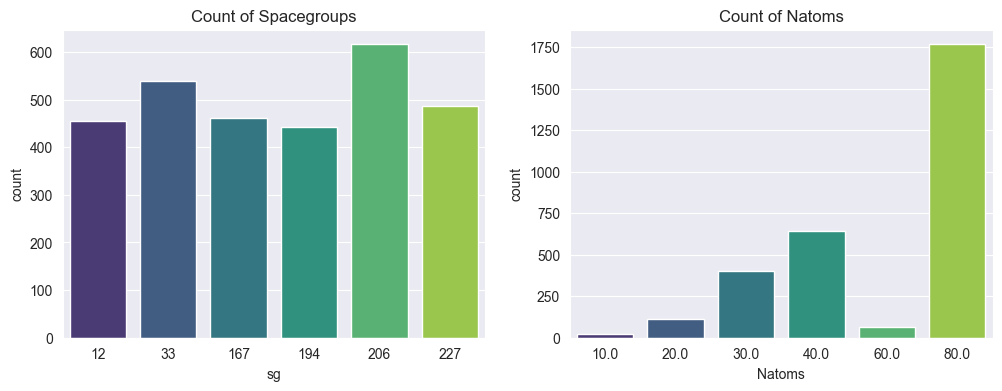

In [50]:
import seaborn as sns
# PLot all the features
# Plot categorical features
# Create subplots for 'sg' and 'Natoms'
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# Plot countplot for 'sg'
sns.countplot(x='sg', data=concatenated_df, palette='viridis', ax=axs[0])
axs[0].set_title('Count of Spacegroups')

# Plot countplot for 'Natoms'
sns.countplot(x='Natoms', data=concatenated_df, palette='viridis', ax=axs[1])
axs[1].set_title('Count of Natoms')

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\3717430564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\3717430564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

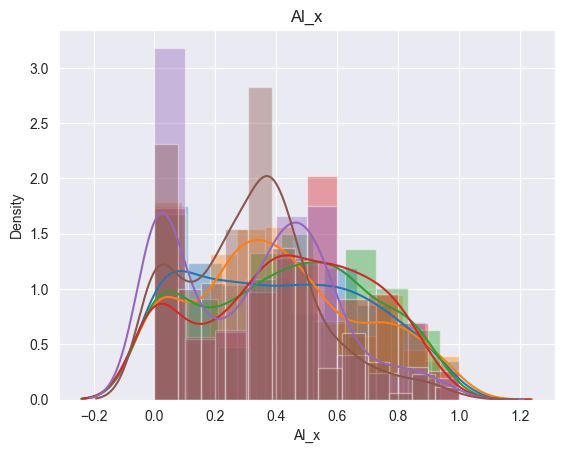

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\3717430564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\3717430564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

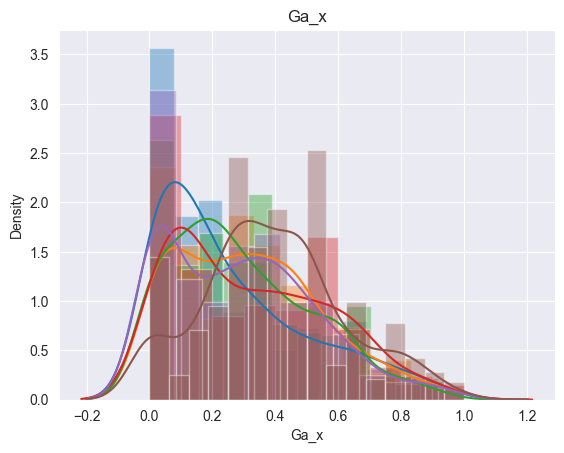

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\3717430564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\3717430564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

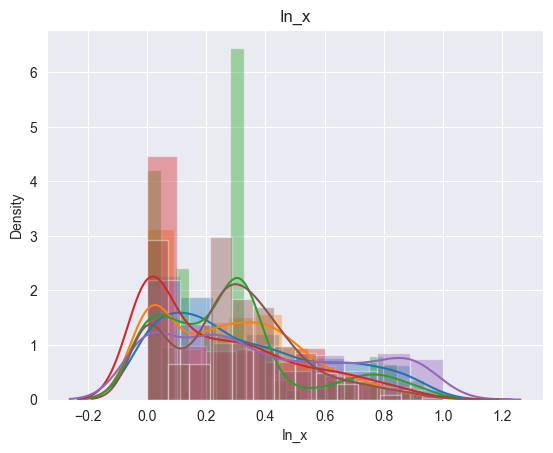

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\3717430564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\3717430564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

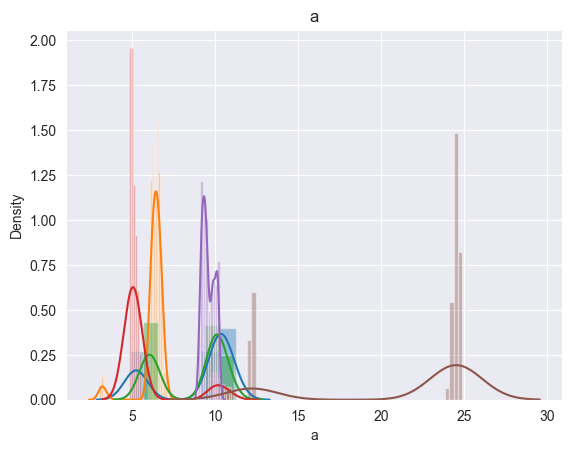

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\3717430564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\3717430564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

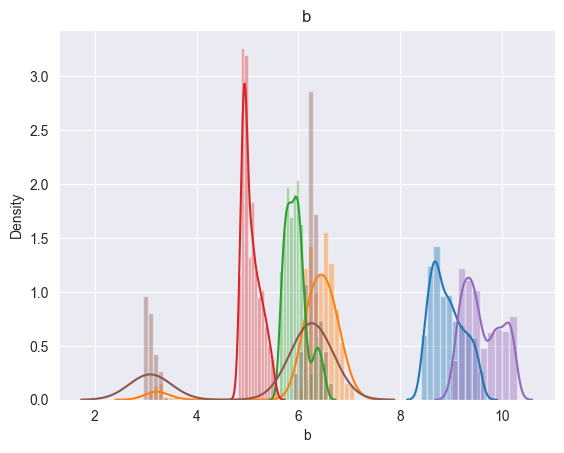

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\3717430564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\3717430564.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

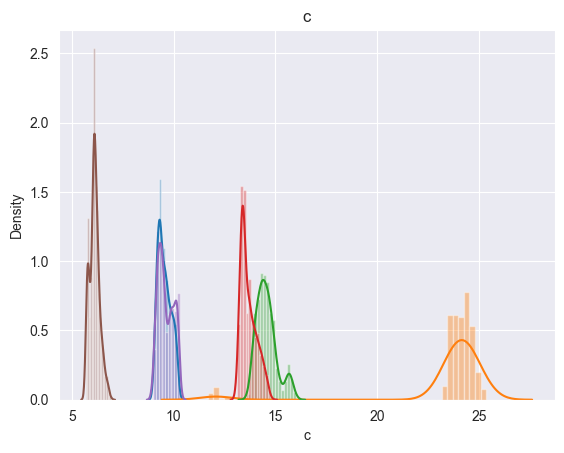

In [68]:
# Plotting numerical features
for col in ['Al_x', 'Ga_x', 'In_x', 'a', 'b', 'c']:
    for x in concatenated_df.sg.unique():
        sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
    plt.title(col)
    plt.show()

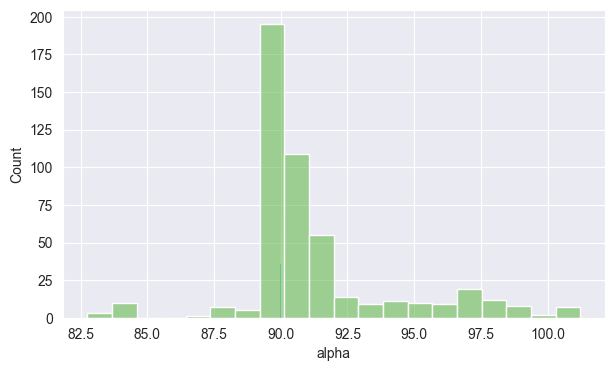

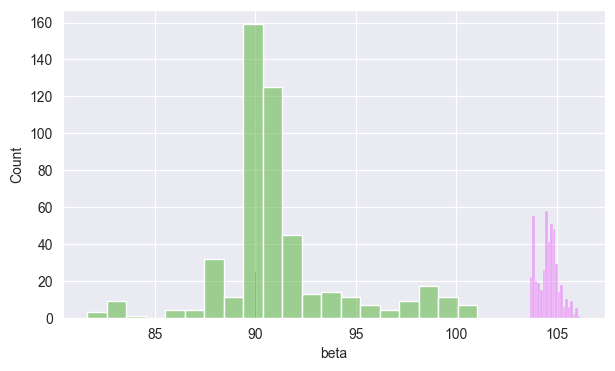

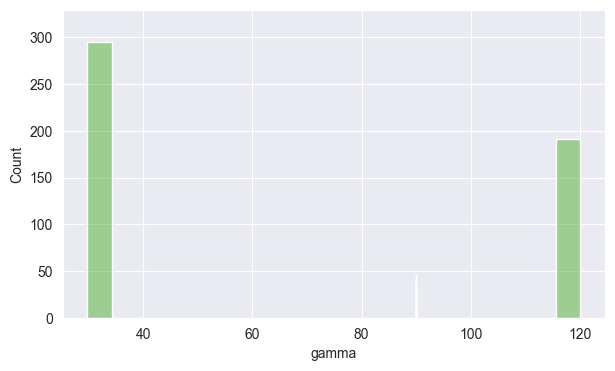

In [77]:
# The angles are plotted separately since they are not very visible in distplot
for angle in ['alpha', 'beta', 'gamma']:
    plt.figure(figsize=(7, 4))  # Adjust the figure size if needed
    for i, x in enumerate(concatenated_df.sg.unique()):
        sns.histplot(concatenated_df[concatenated_df['sg'] == x][angle], bins=20, kde=False, label=x, alpha=0.5, color=sns.color_palette('husl')[i])

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2754258310.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[col], label=x)


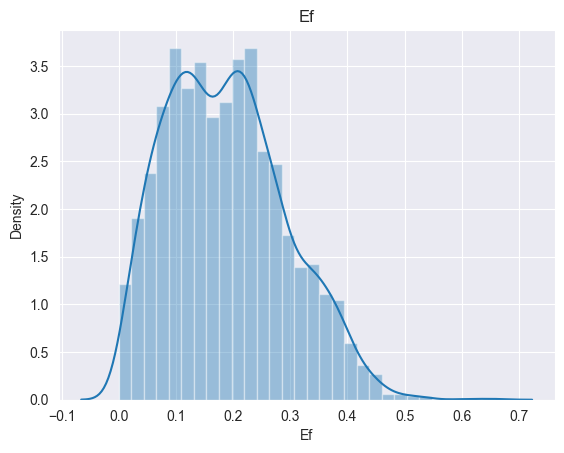

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2754258310.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[col], label=x)


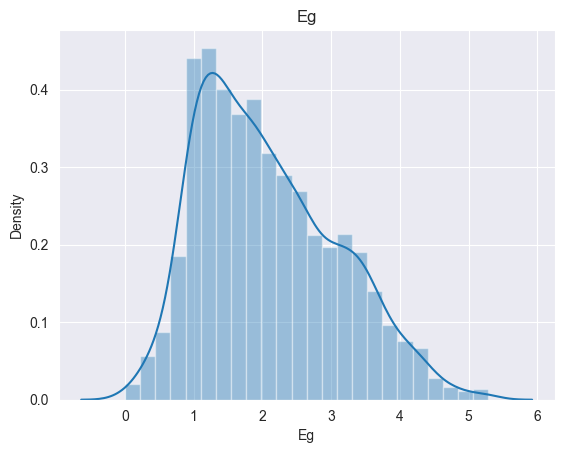

In [87]:
# Plotting the Ef and Eg fpr tje training data
for col in ['Ef', 'Eg']:
    sns.distplot(df_train[col], label=x)
    plt.title(col)
    plt.show()

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

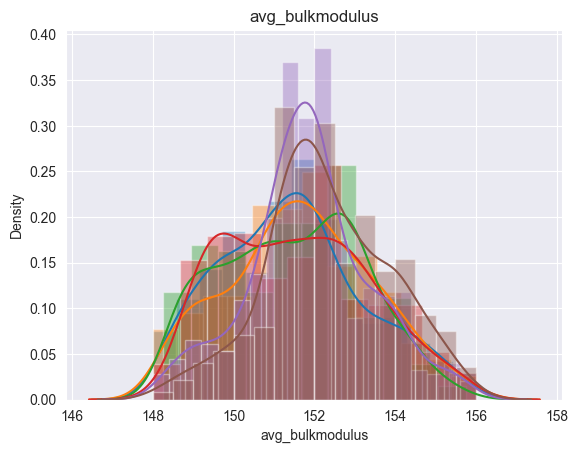

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

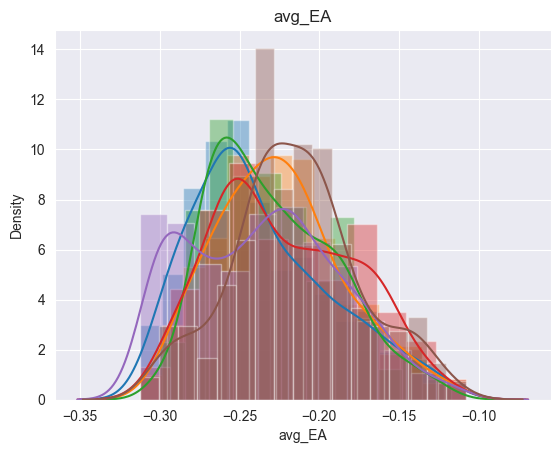

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

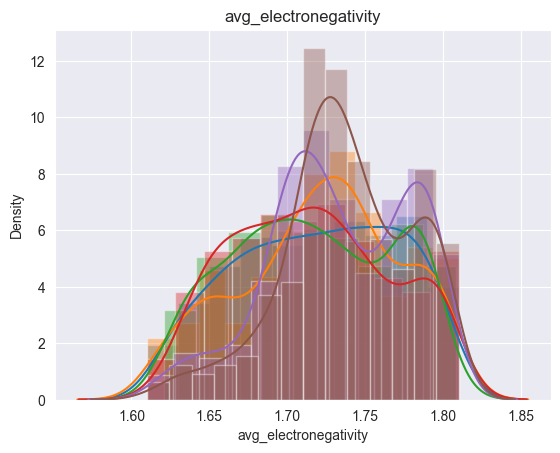

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

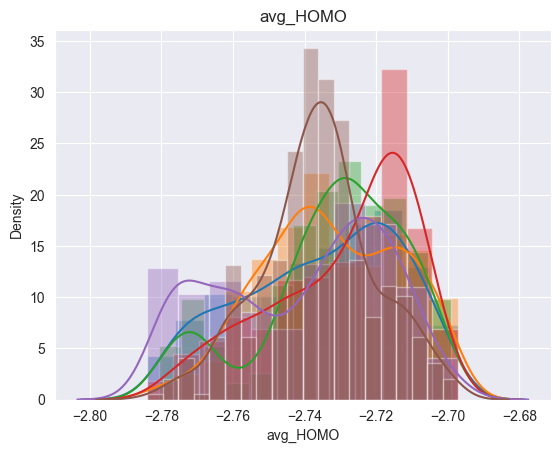

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

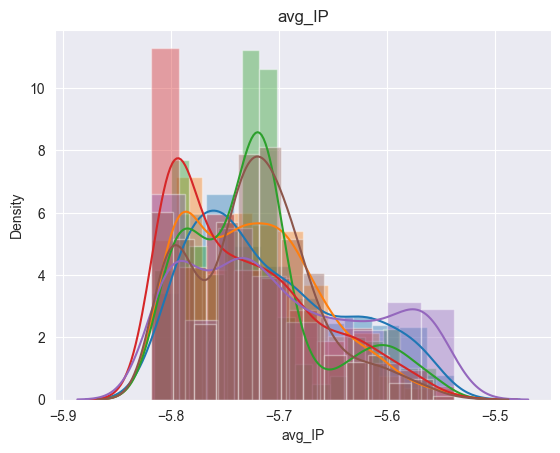

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

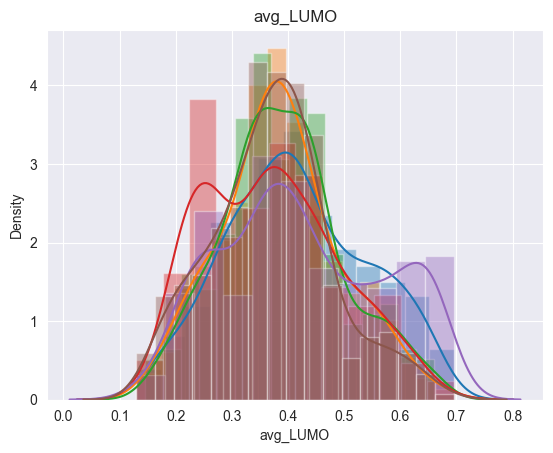

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

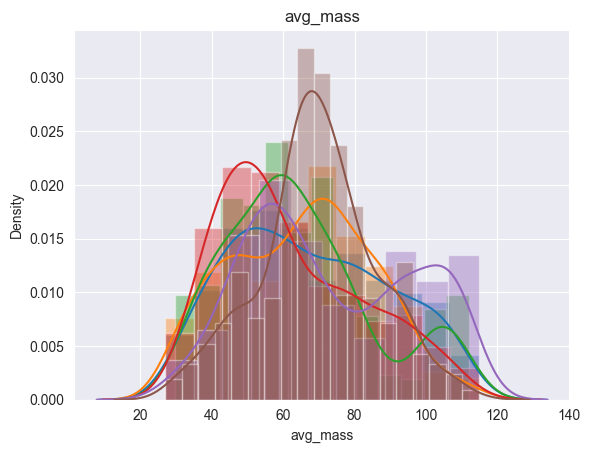

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

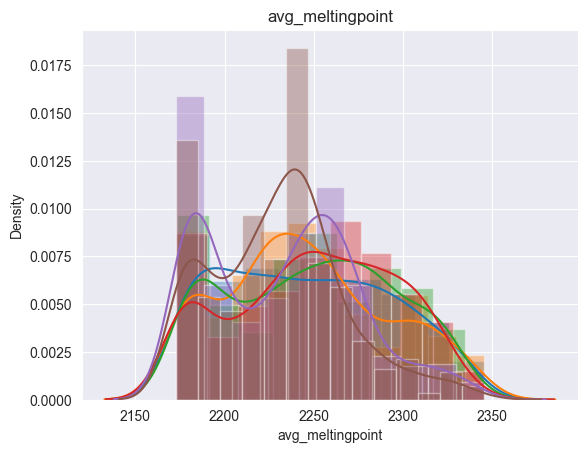

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

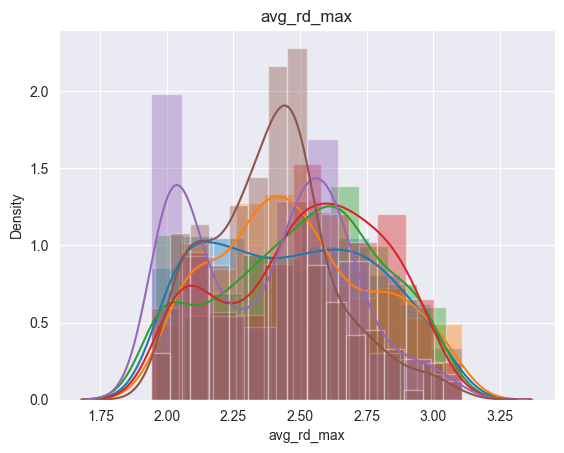

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

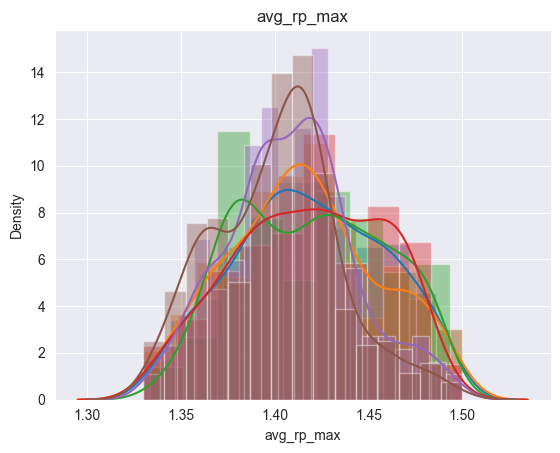

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

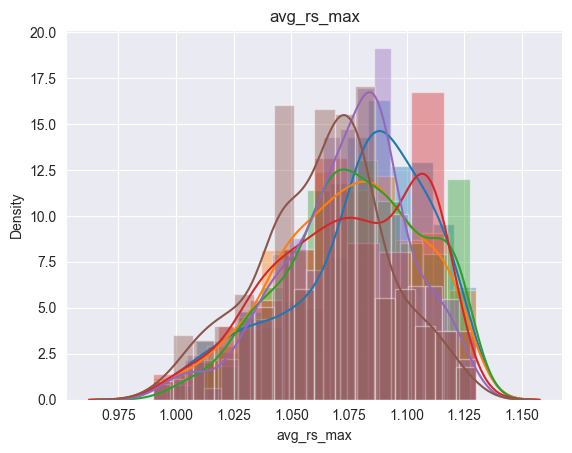

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

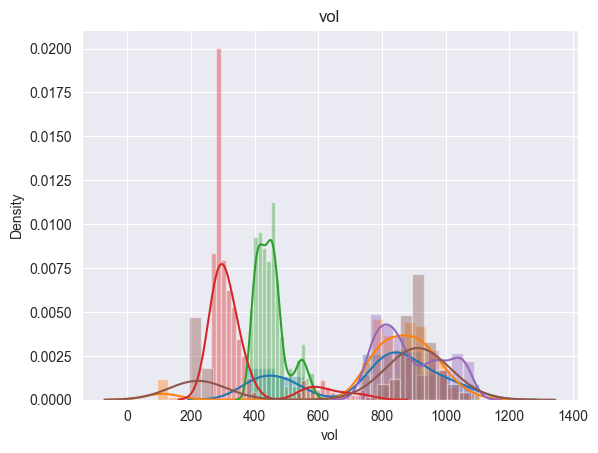

C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
C:\Users\thanh\AppData\Local\Temp\ipykernel_38044\2213422740.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(concatenate

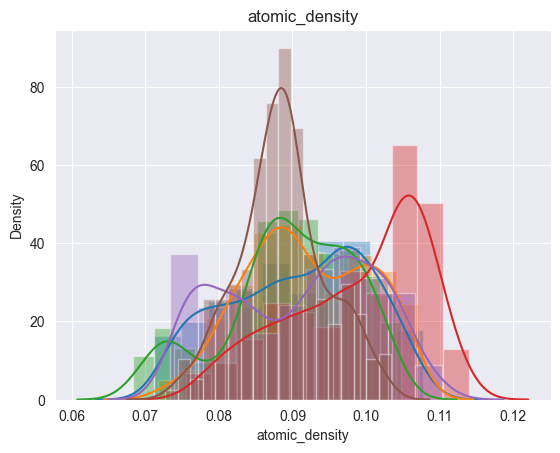

In [90]:
# Plotting the chemical features added
for col in ['avg_bulkmodulus', 'avg_EA', 'avg_electronegativity', 'avg_HOMO', 'avg_IP', 'avg_LUMO', 'avg_mass', 'avg_meltingpoint', 'avg_rd_max', 'avg_rp_max', 'avg_rs_max', 'vol', 'atomic_density']:
    for x in concatenated_df.sg.unique():
        sns.distplot(concatenated_df[concatenated_df['sg'] == x][col], label=x)
    plt.title(col)
    plt.show()

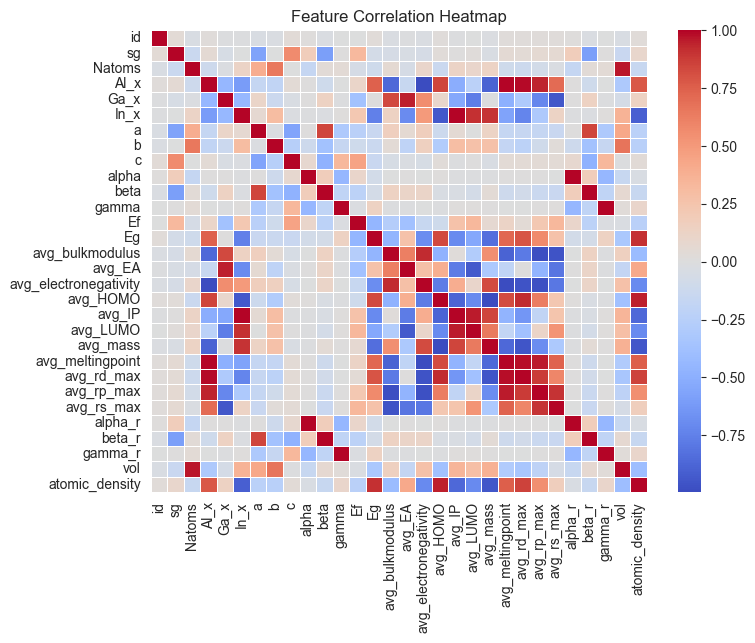

In [94]:
# Correlation matrix
# Calculate the correlation matrix
correlation_matrix = concatenated_df.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

CATBOOST

In [122]:
# Import Catboost
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import r2_score

In [97]:
# Performance metric
def rmsle(h, y):
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [100]:
# Initialize data
X_train = df_train[features]
y_train_Ef = df_train['Ef']
y_train_Eg = df_train['Eg']
X_test = df_test[features]
y_test_Ef = df_test['Ef']
y_test_Eg = df_test['Eg']
y_train = df_train[props]
y_test = df_test[props]

# CATegorical features
"""df_train['Natoms'] = df_train['Natoms'].astype(str)
df_test['Natoms'] = df_test['Natoms'].astype(str)
df_train['sg'] = df_train['sg'].astype(str)
df_test['sg'] = df_test['sg'].astype(str)"""
cat_features = ['sg', 'Natoms']

# Create CatBoost Pools
train_pool_Ef = Pool(X_train, label=y_train_Ef, cat_features=cat_features)
train_pool_Eg = Pool(X_train, label=y_train_Eg, cat_features=cat_features)
train_pool = Pool(X_train, label=y_train, cat_features=cat_features)

In [143]:
# Initialize CatBoost model for both
model = CatBoostRegressor(iterations=1200, depth=6, learning_rate=0.03, loss_function='MultiRMSE', random_seed=42)
model.fit(train_pool, eval_set=train_pool, verbose=10)

0:	learn: 0.9877098	test: 0.9877098	best: 0.9877098 (0)	total: 91.6ms	remaining: 1m 49s
10:	learn: 0.7800539	test: 0.7800539	best: 0.7800539 (10)	total: 1.17s	remaining: 2m 6s
20:	learn: 0.6236639	test: 0.6236639	best: 0.6236639 (20)	total: 2.26s	remaining: 2m 7s
30:	learn: 0.5075918	test: 0.5075918	best: 0.5075918 (30)	total: 3.36s	remaining: 2m 6s
40:	learn: 0.4247688	test: 0.4247688	best: 0.4247688 (40)	total: 4.46s	remaining: 2m 6s
50:	learn: 0.3652792	test: 0.3652792	best: 0.3652792 (50)	total: 5.55s	remaining: 2m 5s
60:	learn: 0.3239478	test: 0.3237040	best: 0.3237040 (60)	total: 6.72s	remaining: 2m 5s
70:	learn: 0.2949361	test: 0.2947755	best: 0.2947755 (70)	total: 7.89s	remaining: 2m 5s
80:	learn: 0.2719570	test: 0.2715788	best: 0.2715788 (80)	total: 9.02s	remaining: 2m 4s
90:	learn: 0.2556516	test: 0.2552252	best: 0.2552252 (90)	total: 10.1s	remaining: 2m 3s
100:	learn: 0.2443079	test: 0.2439227	best: 0.2439227 (100)	total: 11.3s	remaining: 2m 2s
110:	learn: 0.2362505	test: 0.

In [144]:
h =  model.predict(X_test)

# Calculate RMSLE for Ef and Eg
rmsle_Ef = rmsle(np.expm1(h[:, 0]), np.expm1(y_test['Ef']))
rmsle_Eg = rmsle(np.expm1(h[:, 1]), np.expm1(y_test['Eg']))
r2_Ef = r2_score(h[:, 0], y_test['Ef'])
r2_Eg = r2_score(h[:, 1], y_test['Eg'])

# Calculate the average RMSLE
average_rmsle = (rmsle_Ef + rmsle_Eg) / 2
average_r2 = (r2_Ef + r2_Eg) /2

print('Average RMSLE: {:.6f}'.format(average_rmsle))
print('Average R2_Score: {:.6f}'.format(average_r2))

Average RMSLE: 0.139632
Average R2_Score: 0.860377


In [147]:
# Initialize CatBoost model for Ef model
model_Ef = CatBoostRegressor(iterations=2000, depth=6, learning_rate=0.01, loss_function='RMSE', random_seed=42, od_wait=50)
model_Ef.fit(train_pool_Ef, eval_set=train_pool_Ef, verbose=10)

0:	learn: 0.1033787	test: 0.1033787	best: 0.1033787 (0)	total: 91.8ms	remaining: 3m 3s
10:	learn: 0.0970765	test: 0.0970765	best: 0.0970765 (10)	total: 1.12s	remaining: 3m 23s
20:	learn: 0.0914207	test: 0.0914207	best: 0.0914207 (20)	total: 2.26s	remaining: 3m 32s
30:	learn: 0.0862219	test: 0.0862219	best: 0.0862219 (30)	total: 3.43s	remaining: 3m 37s
40:	learn: 0.0815679	test: 0.0815679	best: 0.0815679 (40)	total: 4.52s	remaining: 3m 35s
50:	learn: 0.0773309	test: 0.0773309	best: 0.0773309 (50)	total: 5.74s	remaining: 3m 39s
60:	learn: 0.0734867	test: 0.0734847	best: 0.0734847 (60)	total: 6.83s	remaining: 3m 37s
70:	learn: 0.0698741	test: 0.0698347	best: 0.0698347 (70)	total: 7.9s	remaining: 3m 34s
80:	learn: 0.0665723	test: 0.0665133	best: 0.0665133 (80)	total: 8.96s	remaining: 3m 32s
90:	learn: 0.0637056	test: 0.0636353	best: 0.0636353 (90)	total: 10s	remaining: 3m 30s
100:	learn: 0.0612124	test: 0.0611300	best: 0.0611300 (100)	total: 11.1s	remaining: 3m 28s
110:	learn: 0.0589559	te

In [148]:
h1 =  model_Ef.predict(X_test)
e1 = rmsle(np.expm1(h1), np.expm1(y_test_Ef))
r21 = r2_score(y_test_Ef, h1)
print('RMSLE: {}'.format(e1))
print('R2 Score: {}'.format(r21))

RMSLE: 0.04328529769724423
R2 Score: 0.8347965971296218


In [149]:
# Initialize CatBoost model for Eg model
model_Eg = CatBoostRegressor(iterations=2000, depth=6, learning_rate=0.01, loss_function='RMSE', random_seed=42)
model_Eg.fit(train_pool_Eg, eval_set=train_pool_Eg, verbose=10)

0:	learn: 0.9981679	test: 0.9981679	best: 0.9981679 (0)	total: 90.4ms	remaining: 3m
10:	learn: 0.9203562	test: 0.9203562	best: 0.9203562 (10)	total: 1.38s	remaining: 4m 9s
20:	learn: 0.8496589	test: 0.8496589	best: 0.8496589 (20)	total: 2.41s	remaining: 3m 46s
30:	learn: 0.7858586	test: 0.7858586	best: 0.7858586 (30)	total: 3.62s	remaining: 3m 49s
40:	learn: 0.7273693	test: 0.7273693	best: 0.7273693 (40)	total: 4.72s	remaining: 3m 45s
50:	learn: 0.6749193	test: 0.6749193	best: 0.6749193 (50)	total: 5.84s	remaining: 3m 43s
60:	learn: 0.6279047	test: 0.6279047	best: 0.6279047 (60)	total: 6.89s	remaining: 3m 39s
70:	learn: 0.5853719	test: 0.5853719	best: 0.5853719 (70)	total: 8.22s	remaining: 3m 43s
80:	learn: 0.5465396	test: 0.5465396	best: 0.5465396 (80)	total: 9.27s	remaining: 3m 39s
90:	learn: 0.5114543	test: 0.5114543	best: 0.5114543 (90)	total: 10.6s	remaining: 3m 42s
100:	learn: 0.4801930	test: 0.4801930	best: 0.4801930 (100)	total: 11.7s	remaining: 3m 39s
110:	learn: 0.4510763	tes

In [150]:
h2 =  model_Eg.predict(X_test)
e2 = rmsle(np.expm1(h2), np.expm1(y_test_Eg))
r22 = r2_score(y_test_Eg, h2)
print('RMSLE: {}'.format(e2))
print('R2 Score: {}'.format(r22))

RMSLE: 0.22633386515602025
R2 Score: 0.9538357848150841


In [151]:
RMSLE_score = (e1 + e2) /2
r2_cat = (r21 + r22) /2
print('Final RMSLE: {}'.format(RMSLE_score))
print('Final R2 Score: {}'.format(r2_cat))

Final RMSLE: 0.13480958142663224
Final R2 Score: 0.8943161909723529


In [152]:
from sklearn.model_selection import KFold

In [153]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

all_data = pd.concat((df_train, df_test))
all_data.head()

,id,sg,Natoms,Al_x,Ga_x,In_x,a,b,c,alpha,...,avg_mass,avg_meltingpoint,avg_rd_max,avg_rp_max,avg_rs_max,alpha_r,beta_r,gamma_r,vol,atomic_density
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,...,43.009587,2280.50,2.753750,1.436250,1.07750,1.570842,1.570836,1.570826,781.052081,0.102426
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,...,43.009587,2280.50,2.753750,1.436250,1.07750,1.571121,1.570761,2.094439,782.500110,0.102236
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,...,34.995563,2312.75,2.931875,1.468125,1.10375,1.587705,1.590393,0.532648,391.227531,0.102242
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,...,48.940654,2304.50,2.817500,1.472500,1.12000,1.570601,1.571004,2.094425,293.377334,0.102257
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,...,86.633625,2176.75,2.077500,1.352500,1.02750,1.570727,1.570807,2.094208,944.713843,0.084682


In [154]:
# features to use
features = ['Al_x', 'Ga_x', 'In_x', 'a', 'b', 'c', 'alpha', 'beta',
            'gamma', 'vol', 'atomic_density', 'pca_abc', 'pca_AlGaInDensity']

# two different vectors for pca
vector1 = all_data[['a', 'b', 'c', 'alpha', 'beta', 'gamma']].values
vector2 = all_data[['Al_x', 'Ga_x', 'In_x', 'atomic_density']].values

# use pca to add new features
pca = PCA()
pca.fit(vector1)
all_data['pca_abc'] = pca.transform(vector1)[:,0]

pca = PCA()
pca.fit(vector2)
all_data['pca_AlGaInDensity'] = pca.transform(vector2)[:,0]

# scaling the data. Linear models tend to like more normally distributed
# I tried training on non-scaled, with slightly worse results
scale = StandardScaler()
scaled = scale.fit(all_data[features]).transform(all_data[features])

X_scale = scaled[:df_train.shape[0]]
X_scaled_test = scaled[df_train.shape[0]:]

X_train = all_data[:df_train.shape[0]][features].values
X_test = all_data[df_train.shape[0]:][features].values

y1 = np.log1p(y_train_Ef)
y2 = np.log1p(y_train_Eg)

y12 = np.column_stack((y1, y2))

X_train.shape, y1.shape, y2.shape, y12.shape, X_scaled_test.shape

((2400, 13), (2400,), (2400,), (2400, 2), (600, 13))

In [156]:
# I found these parameters worked for both y variables
cat_1 = CatBoostRegressor(iterations=1000,
                          learning_rate=0.02,
                          depth=6,
                          loss_function='RMSE',
                          eval_metric='RMSE',
                          random_seed= 42,
                          od_type='Iter',
                          od_wait=50,
                         )

def assess_cat(X, y_list, model_num):
    final_rmsle = []
    final_r2 = []
    best_iter = [[], []]
    for idx, y in enumerate(y_list):
        kfold = KFold(n_splits=10, shuffle=True)
        rmsle_out = []
        r2_out = []
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = model_num[idx]
            model.fit(X_train, y_train, verbose=False)

            h =  model.predict(X_test)
            # Calculate RMSLE
            rmsle_val = rmsle(np.expm1(h), np.expm1(y_test))
            rmsle_out.append(rmsle_val)

            # Calculate R-squared
            r2_val = r2_score(y_test, h)
            r2_out.append(r2_val)

            print('RMSLE: {}, R2 Score: {}'.format(rmsle_val, r2_val))

        final_rmsle.append(np.array(rmsle_out).mean())
        final_r2.append(np.array(r2_out).mean())

    return {
        'rmsle_mean': np.array(final_rmsle).mean(),
        'rmsle_std': np.array(final_rmsle).std(),
        'r2_mean': np.array(final_r2).mean(),
        'r2_std': np.array(final_r2).std(),
    }

In [158]:
model = assess_cat(X_train, [y1, y2], [cat_1, cat_1])
print("Model RMSLE: {}, std: {}".format(model['rmsle_mean'], model['rmsle_std']))
print("Model R2 Score: {}, std: {}".format(model['r2_mean'], model['r2_std']))

RMSLE: 0.028627464282145923, R2 Score: 0.8879667245226901
RMSLE: 0.04049289912847869, R2 Score: 0.8049815084780085
RMSLE: 0.0354920795903445, R2 Score: 0.8281655650974398
RMSLE: 0.029445620463321245, R2 Score: 0.8680777792105567
RMSLE: 0.030177486345741078, R2 Score: 0.8861938153622954
RMSLE: 0.03223819828768485, R2 Score: 0.8464643601096775
RMSLE: 0.031732263489523675, R2 Score: 0.8744558668895288
RMSLE: 0.02998372400297969, R2 Score: 0.8698920693025203
RMSLE: 0.035863440433802435, R2 Score: 0.8397973287564259
RMSLE: 0.025739191023465814, R2 Score: 0.9079691536743919
RMSLE: 0.08188807798386358, R2 Score: 0.9304635147659593
RMSLE: 0.09478982327192124, R2 Score: 0.9100764098050795
RMSLE: 0.0900581781558017, R2 Score: 0.9298778439613787
RMSLE: 0.08030987593696433, R2 Score: 0.9391678375273042
RMSLE: 0.08100230195049593, R2 Score: 0.9419348524185007
RMSLE: 0.08973925913005444, R2 Score: 0.9235420740832657
RMSLE: 0.09003247494356259, R2 Score: 0.9211788371057714
RMSLE: 0.08972254984119665,

In [159]:
from sklearn.model_selection import train_test_split

catboost_cv = CatBoostRegressor(iterations=1000,
                            learning_rate=0.02,
                            depth=6,
                            loss_function='RMSE',
                            eval_metric='RMSE',
                            random_seed=42,
                            od_type='Iter',
                            od_wait=50)

def assess_cv_catboost(X, y_list):
    final_rmsle = []
    final_r2 = []
    best_iter = [[], []]
    for idx, y in enumerate(y_list):
        kfold = KFold(n_splits=10, shuffle=True)
        rmsle_out = []
        r2_out = []

        for train_index, test_index in kfold.split(X):
            # splitting the data up into train, test, and valid sets
            X_iter, X_test = X[train_index], X[test_index]
            y_iter, y_test = y[train_index], y[test_index]
            X_train, X_valid, y_train, y_valid = train_test_split(X_iter, y_iter, test_size=0.3)
            model =  catboost_cv
            model.fit(X_train, y_train,
                      eval_set=(X_valid, y_valid),
                      use_best_model=True,
                      verbose=False)

            h =  model.predict(X_test)

            # Calculate RMSLE
            rmsle_val = rmsle(np.expm1(h), np.expm1(y_test))
            rmsle_out.append(rmsle_val)

            # Calculate R-squared
            r2_val = r2_score(y_test, h)
            r2_out.append(r2_val)

            print('RMSLE: {}, R2 Score: {}'.format(rmsle_val, r2_val))

        final_rmsle.append(np.array(rmsle_out).mean())
        final_r2.append(np.array(r2_out).mean())

    return {
        'rmsle_mean': np.array(final_rmsle).mean(),
        'rmsle_std': np.array(final_rmsle).std(),
        'r2_mean': np.array(final_r2).mean(),
        'r2_std': np.array(final_r2).std(),
    }

In [160]:
model_assessment = assess_cat(X_train, [y1, y2], [cat_1, cat_1])
print("Model RMSLE: {}, std: {}".format(model_assessment['rmsle_mean'], model_assessment['rmsle_std']))
print("Model R2 Score: {}, std: {}".format(model_assessment['r2_mean'], model_assessment['r2_std']))

RMSLE: 0.03796028057480607, R2 Score: 0.7986813799026609
RMSLE: 0.0277177389053452, R2 Score: 0.8815895798902433
RMSLE: 0.037157976225030497, R2 Score: 0.812832995932133
RMSLE: 0.03565115719087005, R2 Score: 0.8429984780034767
RMSLE: 0.02738436192787581, R2 Score: 0.8939089114625112
RMSLE: 0.03027741047973915, R2 Score: 0.8865825796883807
RMSLE: 0.03369816289473699, R2 Score: 0.8528251339177845
RMSLE: 0.029605478041230215, R2 Score: 0.8884939143310864
RMSLE: 0.030219431863148193, R2 Score: 0.8596520624845183
RMSLE: 0.03503180080897616, R2 Score: 0.8498382807512712
RMSLE: 0.07949303954986578, R2 Score: 0.9394668636812367
RMSLE: 0.08408962747306967, R2 Score: 0.9404227705138456
RMSLE: 0.09546194448221995, R2 Score: 0.9116863665024443
RMSLE: 0.07918053742358627, R2 Score: 0.9388457690519924
RMSLE: 0.10230775912058317, R2 Score: 0.8973858729285924
RMSLE: 0.10168085764323062, R2 Score: 0.9130840930377746
RMSLE: 0.07187296242751587, R2 Score: 0.9503540581307937
RMSLE: 0.0860085232824874, R2 

RANDOM FOREST

In [161]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

In [162]:
# performance metric
def err(h, y):
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [219]:
rf_features = ['sg', 'Natoms', 'Al_x', 'Ga_x', 'In_x', 'a', 'b', 'c', 'alpha', 'beta', 'gamma', 'avg_bulkmodulus', 'avg_EA', 'avg_electronegativity', 'avg_HOMO', 'avg_IP', 'avg_LUMO', 'avg_mass', 'avg_meltingpoint', 'avg_rd_max', 'avg_rp_max', 'avg_rs_max', 'vol', 'atomic_density']

rf_features_Eg = ['sg', 'a', 'b', 'c', 'alpha', 'beta', 'gamma', 'avg_HOMO', 'avg_IP', 'avg_LUMO', 'avg_rd_max', 'avg_rp_max', 'avg_rs_max', 'atomic_density']

In [220]:
rf_model_Ef = RandomForestRegressor(n_estimators=200, max_depth = 20, random_state=42)
rf_model_Ef.fit(df_train[rf_features], y_train_Ef)

RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)

In [221]:
rf_model_Eg = RandomForestRegressor(n_estimators=200, max_depth = 20, min_samples_split = 5, random_state=42)
rf_model_Eg.fit(df_train[rf_features_Eg], y_train_Eg)

RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=200,
                      random_state=42)

In [223]:
y_pred_Ef = rf_model_Ef.predict(df_test[rf_features])
y_pred_Eg = rf_model_Eg.predict(df_test[rf_features_Eg])

In [224]:
ayy1 = err(np.expm1(y_pred_Ef), np.expm1(y_test_Ef))
lmao1 = r2_score(np.expm1(y_pred_Ef), np.expm1(y_test_Ef))
print('RMSLE Ef: {}'.format(ayy1))
print('R2 Score Ef: {}'.format(lmao1))
ayy2 = err(np.expm1(y_pred_Eg), np.expm1(y_test_Eg))
lmao2 = r2_score(np.expm1(y_pred_Eg), np.expm1(y_test_Eg))
print('RMSLE Eg: {}'.format(ayy2))
print('R2 Score Eg: {}'.format(lmao2))
ayy = (ayy1 + ayy2)/2
lmao = (lmao1 + lmao2)/2
print('Average RMSLE: {}'.format(ayy))
print('Average R2 Score: {}'.format(lmao))

RMSLE Ef: 0.04750763541409118
R2 Score Ef: 0.7286469817049694
RMSLE Eg: 0.25408072861361675
R2 Score Eg: 0.9110793268554757
Average RMSLE: 0.15079418201385397
Average R2 Score: 0.8198631542802226


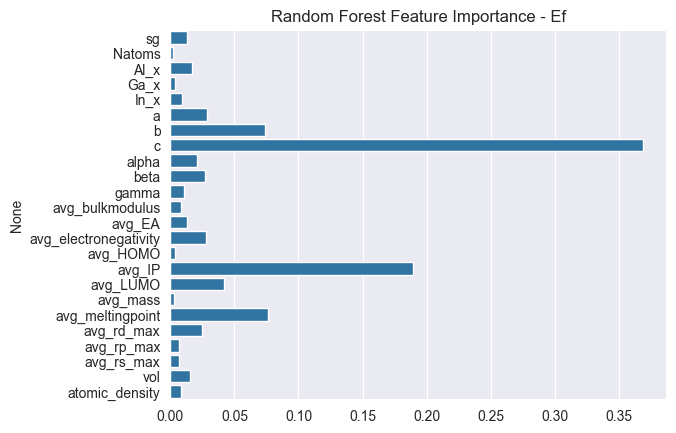

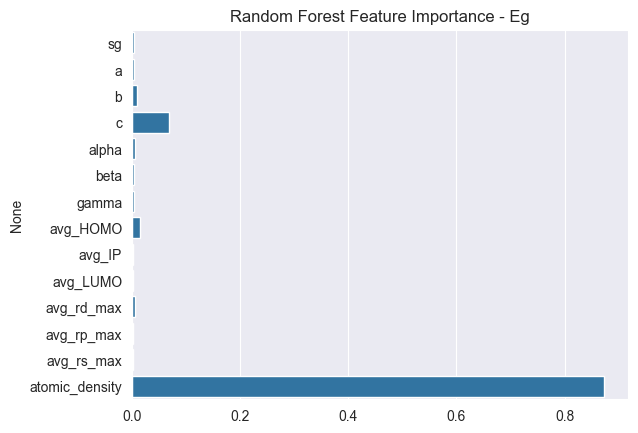

In [226]:
feature_names = df_train[rf_features].columns
feature_names_Eg = df_train[rf_features_Eg].columns

# Feature importance for Ef
feature_importance_Ef = rf_model_Ef.feature_importances_
sns.barplot(x=feature_importance_Ef, y=feature_names, orient='h')
plt.title('Random Forest Feature Importance - Ef')
plt.show()

# Feature importance for Eg
feature_importance_Eg = rf_model_Eg.feature_importances_
sns.barplot(x=feature_importance_Eg, y=feature_names_Eg, orient='h')
plt.title('Random Forest Feature Importance - Eg')
plt.show()

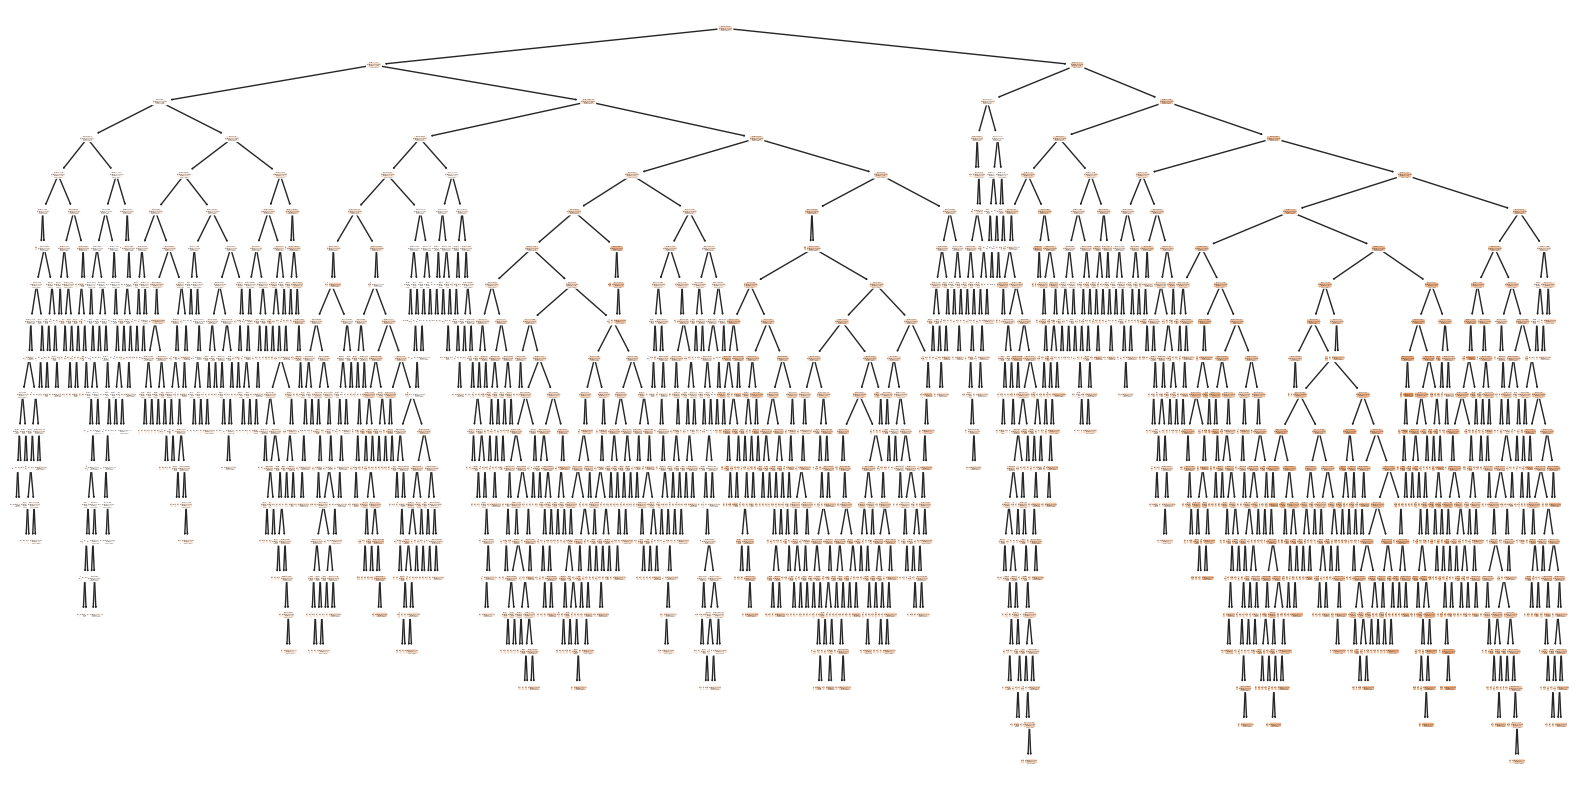

In [205]:
plt.figure(figsize=(20, 10))
plot_tree(rf_model_Ef.estimators_[0], filled=True, rounded=True)
plt.show()

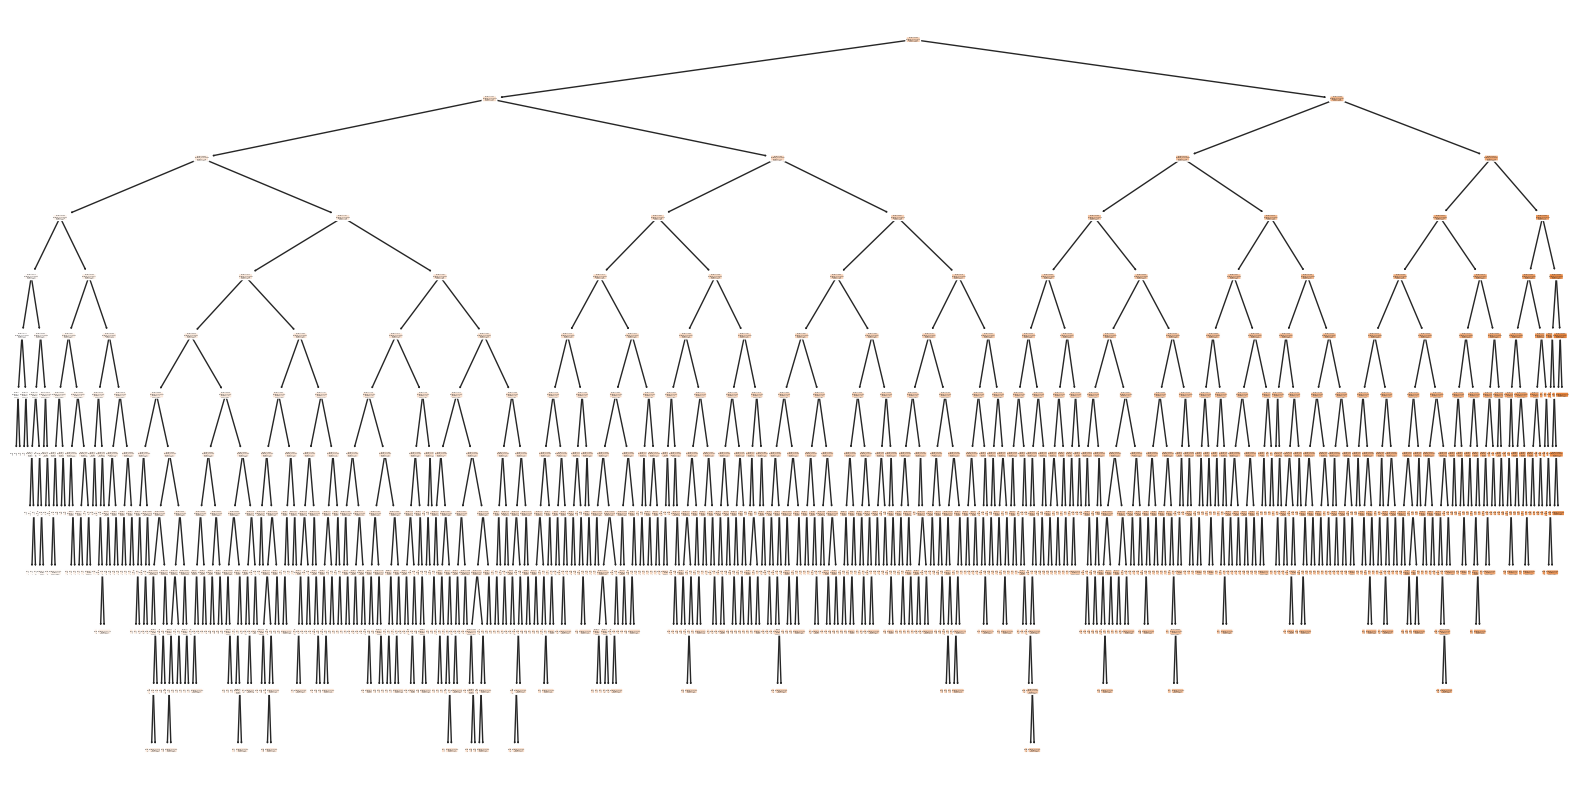

In [168]:
plt.figure(figsize=(20, 10))
plot_tree(rf_model_Eg.estimators_[0], filled=True, rounded=True)
plt.show()

In [281]:
all_data.head()

,id,sg,Natoms,Al_x,Ga_x,In_x,a,b,c,alpha,...,avg_rd_max,avg_rp_max,avg_rs_max,alpha_r,beta_r,gamma_r,vol,atomic_density,pca_abc,pca_AlGaInDensity
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,...,2.753750,1.436250,1.07750,1.570842,1.570836,1.570826,781.052081,0.102426,5.211247,-0.387600
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,...,2.753750,1.436250,1.07750,1.571121,1.570761,2.094439,782.500110,0.102236,-25.993020,-0.387595
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,...,2.931875,1.468125,1.10375,1.587705,1.590393,0.532648,391.227531,0.102242,63.927781,-0.524768
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,...,2.817500,1.472500,1.12000,1.570601,1.571004,2.094425,293.377334,0.102257,-25.318244,-0.308580
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,...,2.077500,1.352500,1.02750,1.570727,1.570807,2.094208,944.713843,0.084682,-26.012421,0.325800


In [282]:
# Assuming 'target_column' is the column you want to predict
#X_rf = all_data.drop(['Ef', 'Eg', 'id'], axis=1)
X_rf = all_data[['sg', 'Natoms', 'Al_x', 'Ga_x', 'In_x', 'a', 'b', 'c', 'alpha', 'beta', 'gamma', 'avg_bulkmodulus', 'avg_EA', 'avg_electronegativity', 'avg_HOMO', 'avg_IP', 'avg_LUMO', 'avg_mass', 'avg_meltingpoint', 'avg_rd_max', 'avg_rp_max', 'avg_rs_max', 'vol', 'atomic_density', 'pca_abc', 'pca_AlGaInDensity']]
y_rf = all_data[['Ef', 'Eg']]

In [250]:
# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

In [251]:
# Fit the model on the training data
rf_model_both = RandomForestRegressor(n_estimators=200, min_samples_split = 5, random_state=42)
rf_model_both.fit(X_train_rf, y_train_rf)

RandomForestRegressor(min_samples_split=5, n_estimators=200, random_state=42)

In [245]:
# Make predictions on the testing data
y_pred_both = rf_model_both.predict(X_test_rf)
rmsle_both = err(np.expm1(y_pred_both), np.expm1(y_test_rf))
r2_both = r2_score(np.expm1(y_test_rf), np.expm1(y_pred_both))
print('RMSLE: {}'.format(rmsle_both.mean()))
print('R2 Score: {}'.format(r2_both.mean()))

RMSLE: 0.13894032027428665
R2 Score: 0.8991666156264453


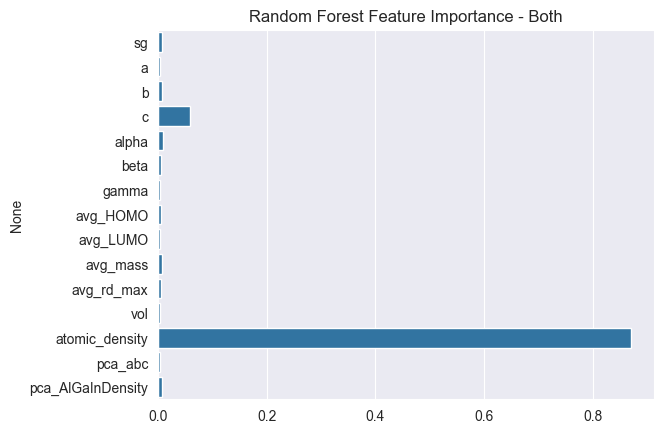

In [252]:
feature_names_both = X_train_rf.columns

# Feature importance for both
feature_importance_both = rf_model_both.feature_importances_
sns.barplot(x=feature_importance_both, y=feature_names_both, orient='h')
plt.title('Random Forest Feature Importance - Both')
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(rf_model_both.estimators_[0], filled=True, rounded=True)
plt.show()

In [260]:
# Random forest without chemical features
df_rf_tr = df_rf_train.drop(['Ef', 'Eg', 'id'], axis = 1)
y_rf_tr = df_rf_train[['Ef', 'Eg']]
df_rf_te = df_rf_test.drop(['Ef', 'Eg', 'id'], axis = 1)
y_rf_te = df_rf_test[['Ef', 'Eg']]

In [262]:
# Fit the model on the training data
rf_model_non = RandomForestRegressor(n_estimators=200, min_samples_split=5, random_state=42)
rf_model_non.fit(df_rf_tr, y_rf_tr)

RandomForestRegressor(min_samples_split=5, n_estimators=200, random_state=42)

In [264]:
# Make predictions on the testing data
y_pred_non = rf_model_non.predict(df_rf_te)
rmsle_non = err(np.expm1(y_pred_non), np.expm1(y_rf_te))
r2_non = r2_score(np.expm1(y_pred_non), np.expm1(y_rf_te))
print('RMSLE: {}'.format(rmsle_non.mean()))
print('R2 Score: {}'.format(r2_non.mean()))

RMSLE: 0.15161217371315852
R2 Score: 0.7946419062102583


In [265]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [283]:
X_rf.head()

,sg,Natoms,Al_x,Ga_x,In_x,a,b,c,alpha,beta,...,avg_LUMO,avg_mass,avg_meltingpoint,avg_rd_max,avg_rp_max,avg_rs_max,vol,atomic_density,pca_abc,pca_AlGaInDensity
0,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,...,0.278750,43.009587,2280.50,2.753750,1.436250,1.07750,781.052081,0.102426,5.211247,-0.387600
1,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,...,0.278750,43.009587,2280.50,2.753750,1.436250,1.07750,782.500110,0.102236,-25.993020,-0.387595
2,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,...,0.323375,34.995563,2312.75,2.931875,1.468125,1.10375,391.227531,0.102242,63.927781,-0.524768
3,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,...,0.449750,48.940654,2304.50,2.817500,1.472500,1.12000,293.377334,0.102257,-25.318244,-0.308580
4,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,...,0.341875,86.633625,2176.75,2.077500,1.352500,1.02750,944.713843,0.084682,-26.012421,0.325800


In [293]:
# Select categorical columns
categorical_cols = ['sg', 'Natoms']

# Select numerical columns
numerical_cols = ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'avg_bulkmodulus',
                   'avg_EA', 'avg_electronegativity', 'avg_HOMO', 'avg_IP', 'avg_LUMO', 'avg_mass',
                   'avg_meltingpoint', 'avg_rd_max', 'avg_rp_max', 'avg_rs_max', 'pca_abc', 'pca_AlGaInDensity']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [294]:
# Apply the transformations to the data
X_rf_encoded = preprocessor.fit_transform(X_rf)

# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf_encoded, y_rf, test_size=0.2, random_state=42)

In [295]:
# Fit the model on the training data
rf_model_code = RandomForestRegressor(n_estimators=200, min_samples_split=5, random_state=42)
rf_model_code.fit(X_train_rf, y_train_rf)

RandomForestRegressor(min_samples_split=5, n_estimators=200, random_state=42)

In [296]:
# Make predictions on the testing data
y_pred_code = rf_model_code.predict(X_test_rf)
rmsle_code = err(np.expm1(y_pred_code), np.expm1(y_test_rf))
r2_code = r2_score(np.expm1(y_pred_code), np.expm1(y_test_rf))
print('RMSLE: {}'.format(rmsle_code.mean()))
print('R2 Score: {}'.format(r2_code.mean()))

RMSLE: 0.14324535425172832
R2 Score: 0.862688835174038


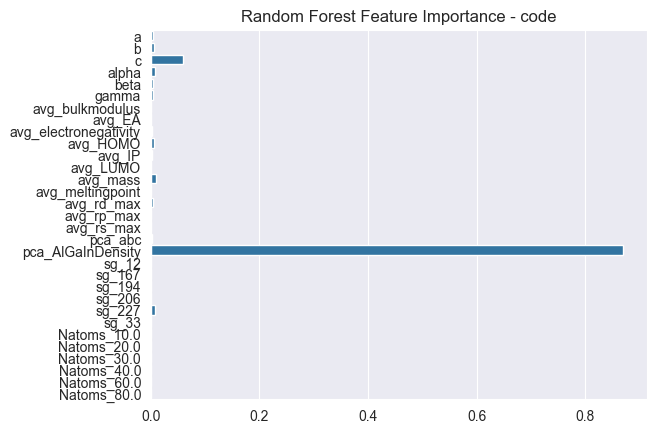

In [298]:
# Get feature names after one-hot encoding
feature_names_code = preprocessor.transformers_[0][2] + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Feature importance for both
feature_importance_code = rf_model_both.feature_importances_

# Plotting the feature importances
sns.barplot(x=feature_importance_code, y=feature_names_code, orient='h')
plt.title('Random Forest Feature Importance - code')
plt.show()